# MEST DAY 5

## Morning Session
### Sequence Models - Time Series Data - RNN - GRU - LSTM

In [ ]:
!pip install tensorflow-gpu==2.0.0.beta0

In [ ]:
#this version of numpy is required to avoid an error related to numpy defaulting to not allowing pickle files
!pip install numpy==1.16.2

In [ ]:
!pip install pandas==0.24

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, preprocessing, models, layers
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('./temperature/jena_climate_2009_2016.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
Date Time          420551 non-null object
p (mbar)           420551 non-null float64
T (degC)           420551 non-null float64
Tpot (K)           420551 non-null float64
Tdew (degC)        420551 non-null float64
rh (%)             420551 non-null float64
VPmax (mbar)       420551 non-null float64
VPact (mbar)       420551 non-null float64
VPdef (mbar)       420551 non-null float64
sh (g/kg)          420551 non-null float64
H2OC (mmol/mol)    420551 non-null float64
rho (g/m**3)       420551 non-null float64
wv (m/s)           420551 non-null float64
max. wv (m/s)      420551 non-null float64
wd (deg)           420551 non-null float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [4]:
df[['Date Time']].head()

,Date Time
0,01.01.2009 00:10:00
1,01.01.2009 00:20:00
2,01.01.2009 00:30:00
3,01.01.2009 00:40:00
4,01.01.2009 00:50:00


In [5]:
df = df[['Date Time', 'T (degC)']]
df['DateTime'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")

In [6]:
df.head()

,Date Time,T (degC),DateTime
0,01.01.2009 00:10:00,-8.02,2009-01-01 00:10:00
1,01.01.2009 00:20:00,-8.41,2009-01-01 00:20:00
2,01.01.2009 00:30:00,-8.51,2009-01-01 00:30:00
3,01.01.2009 00:40:00,-8.31,2009-01-01 00:40:00
4,01.01.2009 00:50:00,-8.27,2009-01-01 00:50:00


In [7]:
df.set_index(['DateTime'])

,Date Time,T (degC)
DateTime,,
2009-01-01 00:10:00,01.01.2009 00:10:00,-8.02
2009-01-01 00:20:00,01.01.2009 00:20:00,-8.41
2009-01-01 00:30:00,01.01.2009 00:30:00,-8.51
2009-01-01 00:40:00,01.01.2009 00:40:00,-8.31
2009-01-01 00:50:00,01.01.2009 00:50:00,-8.27
...,...,...
2016-12-31 23:20:00,31.12.2016 23:20:00,-4.05
2016-12-31 23:30:00,31.12.2016 23:30:00,-3.35
2016-12-31 23:40:00,31.12.2016 23:40:00,-3.16


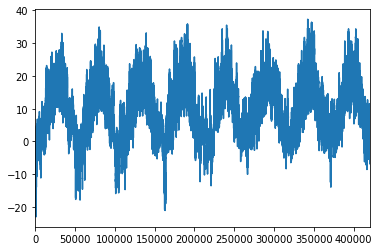

In [9]:
%matplotlib inline
df['T (degC)'].plot()

### Extract Time Series DF

In [10]:
time_series_df = df.set_index(['DateTime'])

In [11]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 2 columns):
Date Time    420551 non-null object
T (degC)     420551 non-null float64
dtypes: float64(1), object(1)
memory usage: 9.6+ MB


In [12]:
time_series_df.drop(['Date Time'], axis=1, inplace=True)

### Resample to Mean Daily Temperature

In [13]:
mean_daily_temp = time_series_df.resample('D').mean()
mean_daily_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: D
Data columns (total 1 columns):
T (degC)    2921 non-null float64
dtypes: float64(1)
memory usage: 45.7 KB


### Create Training and Test

In [14]:
test_daily_temp = mean_daily_temp['2016']
train_daily_temp = mean_daily_temp['2009':'2015']

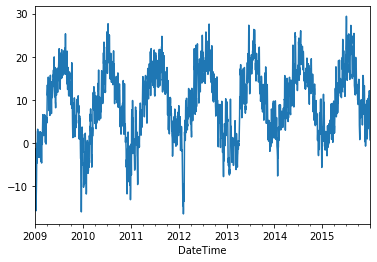

In [15]:
train_daily_temp['T (degC)'].plot()

In [16]:
train_daily_temp.head()

,T (degC)
DateTime,
2009-01-01,-6.810629
2009-01-02,-3.728194
2009-01-03,-5.271736
2009-01-04,-1.375208
2009-01-05,-4.867153


### Reset Index

In [17]:
train_daily_temp.reset_index(inplace=True)
train_daily_temp.reset_index(inplace=True)

In [18]:
test_daily_temp.reset_index(inplace=True)
test_daily_temp.reset_index(inplace=True)
test_daily_temp.head()

,index,DateTime,T (degC)
0,0,2016-01-01,0.249236
1,1,2016-01-02,-0.975486
2,2,2016-01-03,-1.578056
3,3,2016-01-04,-2.081111
4,4,2016-01-05,-1.761319


### Extract Time Steps

In [19]:
train_x = train_daily_temp[['index']].to_numpy()
train_y = train_daily_temp[['T (degC)']].to_numpy()

test_x = test_daily_temp[['index']].to_numpy()
test_y = test_daily_temp[['T (degC)']].to_numpy()

### Create a Generator

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
N_INPUT = 5
BATCH_SIZE = 16

In [22]:
train_gen = TimeseriesGenerator(train_x, train_y, length=N_INPUT, sampling_rate=7, batch_size=BATCH_SIZE)

In [23]:
test_gen = TimeseriesGenerator(test_x, test_y, length=N_INPUT, sampling_rate=7, batch_size=BATCH_SIZE)

### Inspect one item

In [24]:
batch_0 = train_gen[0]
x, y = batch_0
print(y.shape)

(16, 1)


In [25]:
print(x.shape)

(16, 1, 1)


### Dense Model

In [26]:
model = models.Sequential([
    layers.Dense(100, input_shape=(x.shape[1], x.shape[2]), activation='tanh'),
    layers.Flatten(),
    layers.Dense(1)
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 100)            200       
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
model.compile(optimizer='adam', loss='mse')

In [28]:
model.fit_generator(train_gen, epochs=5)

Epoch 1/5
160/160 [==============================] - 1s 9ms/step - loss: 74.3483
Epoch 2/5
160/160 [==============================] - 1s 9ms/step - loss: 61.1254
Epoch 3/5
160/160 [==============================] - 1s 8ms/step - loss: 60.3681
Epoch 4/5
160/160 [==============================] - 1s 9ms/step - loss: 60.9070
Epoch 5/5
160/160 [==============================] - 1s 9ms/step - loss: 59.6517


In [29]:
example = test_gen[0]
x, y = example
y_pred = model.predict(x)
print('Actual: {} | Predicted: {}'.format(y[0], y_pred[0]))

TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type int64 of argument 'a'.

### Train an RNN

In [30]:
rnn_model = models.Sequential([
    layers.SimpleRNN(100, input_shape=(x.shape[1], x.shape[2]), dropout=0.5, recurrent_dropout=0.5),
    layers.Dense(1)
])
print(rnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit_generator(train_gen, epochs=5)

Epoch 1/5
160/160 [==============================] - 2s 13ms/step - loss: 108.1847
Epoch 2/5
160/160 [==============================] - 2s 13ms/step - loss: 84.2854
Epoch 3/5
160/160 [==============================] - 2s 13ms/step - loss: 72.3198
Epoch 4/5
160/160 [==============================] - 2s 12ms/step - loss: 66.9970
Epoch 5/5
160/160 [==============================] - 2s 13ms/step - loss: 63.4673


In [32]:
y_pred = rnn_model.predict(x)
print('Actual: {} | Predicted: {}'.format(y[0], y_pred[0]))

TypeError: Input 'b' of 'MatMul' Op has type float32 that does not match type int64 of argument 'a'.

### Train an LSTM

In [ ]:
lstm_model = models.Sequential([
    layers.Bidirectional(layers.LSTM(100, return_sequences=True, recurrent_dropout=0.5), input_shape=(x.shape[1], x.shape[2])),
    layers.Bidirectional(layers.LSTM(100, recurrent_dropout=0.5)),
    layers.Dense(1)
])
print(lstm_model.summary())

In [ ]:
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit_generator(train_gen, epochs=5)

In [ ]:
y_pred = lstm_model.predict(x)
print('Actual: {} | Predicted: {}'.format(y[0], y_pred[0]))

## Afternoon Session
### Language Models - Encodings - Embeddings - LSTM - 1D-CNN

### IMDB

In [2]:
imdb = datasets.imdb

#Let's work with a dictionary of 20,000 words
NUM_WORDS = 20000

In [3]:
#load IMDB dataset as lists of integers
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=NUM_WORDS, )

17465344/17464789 [==============================] - 12s 1us/step


In [5]:
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k: (v+3) for k, v in word_index.items()}
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<UNUSED>'] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

1646592/1641221 [==============================] - 1s 1us/step


In [6]:
print(' '.join([reverse_word_index[i] for i in train_data[0]]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be p

In [7]:
print(train_labels[0])

1


In [8]:
print(train_labels[:5])

[1 0 0 1 0]


In [9]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


* inspect the length of each review

In [10]:
print('Len 0: {}, Len 1: {}, Len 2: {}'.format(len(train_data[0]), len(train_data[1]), len(train_data[2])))

Len 0: 218, Len 1: 189, Len 2: 141


In [11]:
LEN_WORDS = 300
train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=LEN_WORDS)
test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=LEN_WORDS)

In [12]:
print('Len 0: {}, Len 1: {}, Len 2: {}'.format(len(train_data[0]), len(train_data[1]), len(train_data[2])))

Len 0: 300, Len 1: 300, Len 2: 300


### DNN

In [13]:
dense_model = models.Sequential([
    layers.Dense(300, input_shape=(300,), activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
print(dense_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               90300     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 361,501
Trainable params: 361,501
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dense_model.fit(train_data, train_labels, epochs=10)

Train on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 124us/sample - loss: 15.2889 - accuracy: 0.5040
Epoch 2/10
25000/25000 [==============================] - 2s 97us/sample - loss: 0.7071 - accuracy: 0.5038
Epoch 3/10
25000/25000 [==============================] - 3s 105us/sample - loss: 0.6932 - accuracy: 0.4995
Epoch 4/10
25000/25000 [==============================] - 2s 98us/sample - loss: 0.6918 - accuracy: 0.5010
Epoch 5/10
25000/25000 [==============================] - 3s 108us/sample - loss: 0.6928 - accuracy: 0.5044 - loss: 0.6929 
Epoch 6/10
25000/25000 [==============================] - 3s 101us/sample - loss: 0.6982 - accuracy: 0.4978
Epoch 7/10
25000/25000 [==============================] - 3s 104us/sample - loss: 0.6938 - accuracy: 0.4940
Epoch 8/10
25000/25000 [==============================] - 2s 100us/sample - loss: 0.6932 - accuracy: 0.4967
Epoch 9/10
25000/25000 [==============================] - 3s 106us/sample - loss: 0.6930 - accurac

### Embeddings

In [18]:
DIMENSION = 16

e_model = models.Sequential([
    layers.Embedding(NUM_WORDS, DIMENSION, input_length=LEN_WORDS),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])
print(e_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 16)           320000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 320,017
Trainable params: 320,017
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
e_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
e_model.fit(train_data, train_labels, epochs=3)

Train on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 2s 98us/sample - loss: 0.6424 - accuracy: 0.7346
Epoch 2/3
25000/25000 [==============================] - 2s 82us/sample - loss: 0.4824 - accuracy: 0.8375
Epoch 3/3
25000/25000 [==============================] - 2s 83us/sample - loss: 0.3722 - accuracy: 0.8741


### Embeddings plus LSTM

In [19]:
l_model = models.Sequential([
    layers.Embedding(NUM_WORDS, DIMENSION, input_length=LEN_WORDS),
    layers.LSTM(DIMENSION * 2),
    layers.Dense(1, activation='sigmoid')
])
print(l_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 16)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 326,305
Trainable params: 326,305
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
l_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
l_model.fit(train_data, train_labels, epochs=3)

### Embeddings plus Convolution

In [20]:
c_model = models.Sequential([
    layers.Embedding(NUM_WORDS, DIMENSION, input_length=LEN_WORDS),
    layers.SeparableConv1D(filters=10, kernel_size=3, strides=3, padding='same'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])
print(c_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 16)           320000    
_________________________________________________________________
separable_conv1d (SeparableC (None, 100, 10)           218       
_________________________________________________________________
global_average_pooling1d_2 ( (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 320,229
Trainable params: 320,229
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
c_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
c_model.fit(train_data, train_labels, epochs=3)

### Amazon Reviews Dataset
* http://jmcauley.ucsd.edu/data/amazon/

In [21]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/gdrive/My Drive/amazon_reviews/reviews_Automotive_5.json.gz')

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/amazon_reviews/reviews_Automotive_5.json.gz'

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df = df[['reviewText', 'overall']]

In [ ]:
print(df['reviewText'][0])

### Remove Special Characters

In [ ]:
import re

def strip_special_chars(st):
    my_pattern = '[A-Za-z0-9./ ]+'
    return ''.join(re.findall(my_pattern, st))

In [ ]:
df['cleanReviewText'] = df['reviewText'].apply(strip_special_chars)
print(df['cleanReviewText'][0])

### Convert Ratings to Sentiment

In [ ]:
def sentiment(x):
    if x < 3:
        return 0
    else:
        return 1
df['sentiment'] = df['overall'].apply(lambda x: sentiment(x))
df[['cleanReviewText', 'overall', 'sentiment']].head()

### create features and labels

In [ ]:
features = df['cleanReviewText']
labels = df['sentiment']

### Get a pre-trained embedding

In [ ]:
import tensorflow_hub as hub

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", output_shape=[50], input_shape=[], dtype=tf.string)

### Add pre-trained layer to a model

In [ ]:
from tensorflow import keras

model = keras.Sequential([
    hub_layer,
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
print(model.summary())

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=features.to_numpy(), y=labels.to_numpy(), epochs=1, validation_split=0.3)

In [ ]:
model = keras.Sequential([
    hub_layer,
    keras.layers.Conv1D(filters=10, kernel_size=3),
    keras.layers.Dense(1, activation='sigmoid')
])
print(model.summary())